In [2]:
import frites
import time
from   tqdm                import tqdm
import cupy                               as cp
import cupyx                              as cpx
import numpy                              as np
import matplotlib.pyplot                  as plt 
import scipy                              as sp
from   cupyx.scipy.special import digamma as psi
from   frites.io           import set_log_level, logger

### CPU

In [2]:
def nd_reshape(x, mvaxis=None, traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    assert isinstance(traxis, int)
    traxis = np.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., np.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = np.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = np.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def cmi_nd_ggg(x, y, z, mvaxis=None, traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = np.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = np.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = np.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = np.linalg.cholesky(cz)
    chcxz = np.linalg.cholesky(cxz)
    chcyz = np.linalg.cholesky(cyz)
    chcxyz = np.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = np.log(np.einsum('...ii->...i', chcz)).sum(-1)
    hxz = np.log(np.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = np.log(np.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = np.log(np.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = np.log(2)
    if biascorrect:
        vec = np.arange(1, nvarxyz + 1)
        psiterms = sp.special.psi((ntrl - vec).astype(np.float) / 2.0) / 2.0
        dterm = (ln2 - np.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    return i

In [3]:
def nd_reshape_gpu(x, mvaxis=None, traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    assert isinstance(traxis, int)
    traxis = cp.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., cp.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = cp.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = cp.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def cmi_nd_ggg_gpu(x, y, z, mvaxis=None, traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape_gpu(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape_gpu(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape_gpu(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = cp.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = cp.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = cp.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = cp.linalg.cholesky(cz)
    chcxz = cp.linalg.cholesky(cxz)
    chcyz = cp.linalg.cholesky(cyz)
    chcxyz = cp.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = cp.log(cp.einsum('...ii->...i', chcz)).sum(-1)
    hxz = cp.log(cp.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = cp.log(cp.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = cp.log(cp.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = cp.log(2)
    if biascorrect:
        vec = cp.arange(1, nvarxyz + 1)
        psiterms = psi((ntrl - vec).astype(cp.float) / 2.0) / 2.0
        dterm = (ln2 - cp.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    cp._default_memory_pool.free_all_blocks()
    return i

In [3]:
# Generating coupled gaussian variables
def return_coupled_normal(Trials = 1, Regions = 3, N = 1000, rho = 0.7):
    E = np.random.normal(0, rho, size=(Trials, Regions, N))
    return E[:,0,:], E[:,1,:], E[:,2,:]

In [5]:
x, y, z = return_coupled_normal(Trials = 1, Regions = 3, N = 1000, rho = 0.7)

In [6]:
cmi_nd_ggg(x, y, z, mvaxis=1, traxis=-1, biascorrect=True,
           demeaned=False, shape_checking=False)

0.0007696416529330326

In [7]:
x_gpu, y_gpu, z_gpu = cp.array(x), cp.array(y), cp.array(z)  

In [8]:
cmi_nd_ggg_gpu(x_gpu, y_gpu, z_gpu, mvaxis=1, traxis=-1, biascorrect=True,
           demeaned=False, shape_checking=False)

array(0.00076964)

In [9]:
# Computing for different series length
N_arr = np.linspace(1000, 1000000, 10, dtype = int)
exta  = np.zeros([2, len(N_arr)])
exts  = np.zeros([2, len(N_arr)])

In [10]:
for i in tqdm( range(N_arr.shape[-1]) ):
    x, y, z = return_coupled_normal(Trials = 1, Regions = 3, N = N_arr[i], rho = 0.7)
    aux = %timeit -o cmi_nd_ggg(x, y, z, mvaxis=1, traxis=-1, \
                                biascorrect=True, demeaned=False, shape_checking=False)
    exta[0,i] = aux.average
    exts[0,i] = aux.stdev
    # GPU 
    x_gpu, y_gpu, z_gpu = cp.array(x), cp.array(y), cp.array(z) 
    aux = %timeit -o cmi_nd_ggg_gpu(x_gpu, y_gpu, z_gpu, mvaxis=1, traxis=-1, \
                                    biascorrect=True,demeaned=False, shape_checking=False)   
    exta[1,i] = aux.average
    exts[1,i] = aux.stdev

  0%|          | 0/10 [00:00<?, ?it/s]

145 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


 10%|█         | 1/10 [00:13<02:01, 13.53s/it]

2.1 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.35 ms ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 20%|██        | 2/10 [00:26<01:47, 13.47s/it]

2.76 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.53 ms ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 30%|███       | 3/10 [00:30<01:14, 10.64s/it]

2.38 ms ± 6.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.72 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 40%|████      | 4/10 [00:36<00:54,  9.02s/it]

2.66 ms ± 29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 50%|█████     | 5/10 [00:42<00:41,  8.31s/it]

3.1 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.27 ms ± 40.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 60%|██████    | 6/10 [00:50<00:33,  8.26s/it]

3.64 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.73 ms ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 70%|███████   | 7/10 [01:00<00:26,  8.74s/it]

4.3 ms ± 9.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.11 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 80%|████████  | 8/10 [01:12<00:19,  9.57s/it]

4.89 ms ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


 90%|█████████ | 9/10 [01:26<00:11, 11.05s/it]

5.41 ms ± 791 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.7 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


100%|██████████| 10/10 [01:42<00:00, 10.30s/it]

6.03 ms ± 66.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


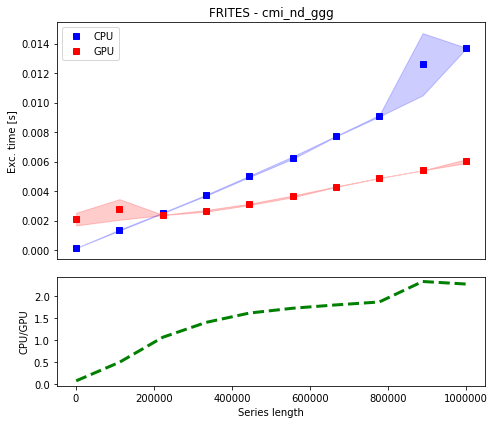

In [11]:
plt.figure(figsize=(7,6))
plt.subplot2grid((3,2), (0,0), rowspan = 2, colspan = 2)
plt.plot(N_arr, exta[0], 'sb', label = 'CPU')
plt.fill_between(N_arr, exta[0]-2*exts[0], exta[0]+2*exts[0], color = 'b', alpha = .2)
plt.plot(N_arr, exta[1], 'sr', label = 'GPU')
plt.fill_between(N_arr, exta[1]-2*exts[1], exta[1]+2*exts[1], color = 'r', alpha = .2)
plt.xticks([])
plt.title('FRITES - cmi_nd_ggg')
plt.ylabel('Exc. time [s]')
plt.legend()
plt.subplot2grid((3,2), (2,0), rowspan = 1, colspan = 2)
plt.plot(N_arr, exta[0]/exta[1], 'g--', lw = 3)
plt.ylabel(r'CPU/GPU')
plt.xlabel('Series length')
plt.tight_layout()
plt.savefig('cmi_nd_ggg.pdf', dpi = 600)

### Agnostic

In [4]:
def get_cupy(target='auto', verbose=None):
    """Get CuPy (if installed) otherwise get NumPy.
    Parameters
    ----------
    target : {'cpu', 'gpu', 'auto'}
        Specify if it's a CPU or GPU context. If auto, GPU is preferred but if
        it's failing, CPU is returned
    """
    set_log_level(verbose)
    assert target in ['cpu', 'gpu', 'auto']

    # ___________________________ Internal switches ___________________________

    def _get_np():
        import numpy as np
        cp = np
        cp.asnumpy = np.asarray
        return 'cpu', cp

    def _get_cp():
        import cupy as cp
        return 'gpu', cp

    # _____________________________ Global switch _____________________________
    if target == 'cpu':
        return _get_np()
    elif target == 'gpu':
        return _get_cp()
    elif target == 'auto':
        try:
            tgt, cp =  _get_cp()
            logger.info('Cupy imported')
        except:
            tgt, cp = _get_np()
            logger.error('Cannot import cupy. Using Numpy instead')
        return tgt, cp

def get_special(target='auto', verbose=None):
    """Get Cupyx special (if installed) otherwise get Scipy special.
    Parameters
    ----------
    target : {'cpu', 'gpu', 'auto'}
        Specify if it's a CPU or GPU context. If auto, GPU is preferred but if
        it's failing, CPU is returned
    """
    set_log_level(verbose)
    assert target in ['cpu', 'gpu', 'auto']

    # ___________________________ Internal switches ___________________________

    def _get_sp():
        import scipy.special as sp
        return 'cpu', sp

    def _get_cxsp():
        import cupyx.scipy.special as sp
        return 'gpu', sp

    # _____________________________ Global switch _____________________________
    if target == 'cpu':
        return _get_sp()
    elif target == 'gpu':
        return _get_cxsp()
    elif target == 'auto':
        try:
            tgt, sp =  _get_cxsp()
            logger.info('Cupy imported')
        except:
            tgt, sp = _get_sp()
            logger.error('Cannot import cupy. Using Scipy special instead')
        return tgt, sp

def get_cusignal(target='auto', verbose=False):
    """Get cusignal (if installed) otherwise get scipy.signal."""
    set_log_level(verbose)
    assert target in ['cpu', 'gpu', 'auto']

    # ___________________________ Internal switches ___________________________

    def _get_sp():
        from scipy import signal
        return 'cpu', signal

    def _get_cs():
        import cusignal
        return 'gpu', cusignal

    # _____________________________ Global switch _____________________________
    if target == 'cpu':
        return _get_sp()
    elif target == 'gpu':
        return _get_cs()
    elif target == 'auto':
        try:
            tgt, cs = _get_cs()
            logger.info('Cusignal imported')
        except:
            tgt, cs = _get_sp()
            logger.error('Cannot import cusignal. Using scipy.signal instead')
        return tgt, cs

In [8]:
def nd_reshape(x, mvaxis=None, target = 'auto', traxis=-1):
    """Multi-dimentional reshaping.
    This function is used to be sure that an nd array has a correct shape
    of (..., mvaxis, traxis).
    Parameters
    ----------
    x : array_like
        Multi-dimentional array
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    Returns
    -------
    x_rsh : array_like
        The reshaped multi-dimentional array of shape (..., mvaxis, traxis)
    """
    _, cp = get_cupy(target=target)
    
    assert isinstance(traxis, int)
    traxis = cp.arange(x.ndim)[traxis]

    # Create an empty mvaxis axis
    if not isinstance(mvaxis, int):
        x = x[..., cp.newaxis]
        mvaxis = -1
    assert isinstance(mvaxis, int)
    mvaxis = cp.arange(x.ndim)[mvaxis]

    # move the multi-variate and trial axis
    x = cp.moveaxis(x, (mvaxis, traxis), (-2, -1))

    return x

def cmi_nd_ggg(x, y, z, mvaxis=None, target='auto', traxis=-1, biascorrect=True,
               demeaned=False, shape_checking=True):
    """Multi-dimentional MI between three Gaussian variables in bits.
    This function is based on ANOVA style model comparison.
    Parameters
    ----------
    x, y, z : array_like
        Arrays to consider for computing the Mutual Information. The three
        input variables x, y and z should have the same shape except on the
        mvaxis (if needed).
    mvaxis : int | None
        Spatial location of the axis to consider if multi-variate analysis
        is needed
    traxis : int | -1
        Spatial location of the trial axis. By default the last axis is
        considered
    biascorrect : bool | True
        Specifies whether bias correction should be applied to the estimated MI
    demeaned : bool | False
        Specifies whether the input data already has zero mean (true if it has
        been copula-normalized)
    shape_checking : bool | True
        Perform a reshape and check that x and y shapes are consistents. For
        high performances and to avoid extensive memory usage, it's better to
        already have x and y with a shape of (..., mvaxis, traxis) and to set
        this parameter to False
    Returns
    -------
    mi : array_like
        The mutual information with the same shape as x, y and z without the
        mvaxis and traxis
    """
    tg, cp = get_cupy(target=target)
    _,  sp = get_special(target=target)
    
    if target=='gpu' and isinstance(x, np.ndarray):
        x = cp.array(x)
    if target=='gpu' and isinstance(y, np.ndarray):
        y = cp.array(y)
    
    # Multi-dimentional shape checking
    if shape_checking:
        x = nd_reshape_gpu(x, mvaxis=mvaxis, traxis=traxis)
        y = nd_reshape_gpu(y, mvaxis=mvaxis, traxis=traxis)
        z = nd_reshape_gpu(z, mvaxis=mvaxis, traxis=traxis)
        nd_shape_checking(x, y, mvaxis, traxis)
        nd_shape_checking(x, z, mvaxis, traxis)

    # x.shape == y.shape == z.shape (..., x_mvaxis, traxis)
    ntrl = x.shape[-1]
    nvarx, nvary, nvarz = x.shape[-2], y.shape[-2], z.shape[-2]
    nvarxy = nvarx + nvary
    nvaryz = nvary + nvarz
    nvarxy = nvarx + nvary
    nvarxz = nvarx + nvarz
    nvarxyz = nvarx + nvaryz

    # joint variable along the mvaxis
    xyz = cp.concatenate((x, y, z), axis=-2)
    if not demeaned:
        xyz -= xyz.mean(axis=-1, keepdims=True)
    cxyz = cp.einsum('...ij, ...kj->...ik', xyz, xyz)
    cxyz /= float(ntrl - 1.)

    # submatrices of joint covariance
    cz = cxyz[..., nvarxy:, nvarxy:]
    cyz = cxyz[..., nvarx:, nvarx:]
    sh = list(cxyz.shape)
    sh[-1], sh[-2] = nvarxz, nvarxz
    cxz = cp.zeros(tuple(sh), dtype=float)
    cxz[..., :nvarx, :nvarx] = cxyz[..., :nvarx, :nvarx]
    cxz[..., :nvarx, nvarx:] = cxyz[..., :nvarx, nvarxy:]
    cxz[..., nvarx:, :nvarx] = cxyz[..., nvarxy:, :nvarx]
    cxz[..., nvarx:, nvarx:] = cxyz[..., nvarxy:, nvarxy:]

    # Cholesky decomposition
    chcz = cp.linalg.cholesky(cz)
    chcxz = cp.linalg.cholesky(cxz)
    chcyz = cp.linalg.cholesky(cyz)
    chcxyz = cp.linalg.cholesky(cxyz)

    # entropies in nats
    # normalizations cancel for mutual information
    hz = cp.log(cp.einsum('...ii->...i', chcz)).sum(-1)
    hxz = cp.log(cp.einsum('...ii->...i', chcxz)).sum(-1)
    hyz = cp.log(cp.einsum('...ii->...i', chcyz)).sum(-1)
    hxyz = cp.log(cp.einsum('...ii->...i', chcxyz)).sum(-1)

    ln2 = cp.log(2)
    if biascorrect:
        vec = cp.arange(1, nvarxyz + 1)
        psiterms = sp.digamma((ntrl - vec).astype(cp.float) / 2.0) / 2.0
        dterm = (ln2 - cp.log(ntrl - 1.0)) / 2.0
        hz = hz - nvarz * dterm - psiterms[:nvarz].sum()
        hxz = hxz - nvarxz * dterm - psiterms[:nvarxz].sum()
        hyz = hyz - nvaryz * dterm - psiterms[:nvaryz].sum()
        hxyz = hxyz - nvarxyz * dterm - psiterms[:nvarxyz].sum()

    # MI in bits
    i = (hxz + hyz - hxyz - hz) / ln2
    if target == 'gpu':
        cp._default_memory_pool.free_all_blocks()
    return i

In [9]:
# Computing for different series length
N_arr = np.linspace(1000, 1000000, 10, dtype = int)
exta  = np.zeros([2, len(N_arr)])
exts  = np.zeros([2, len(N_arr)])

In [10]:
for i in tqdm( range(N_arr.shape[-1]) ):
    x, y, z = return_coupled_normal(Trials = 1, Regions = 3, N = N_arr[i], rho = 0.7)
    aux = %timeit -o cmi_nd_ggg(x, y, z, mvaxis=1, target = 'cpu', traxis=-1, \
                                biascorrect=True, demeaned=False, shape_checking=False)
    exta[0,i] = aux.average
    exts[0,i] = aux.stdev
    # GPU 
    x_gpu, y_gpu, z_gpu = cp.array(x), cp.array(y), cp.array(z) 
    aux = %timeit -o cmi_nd_ggg(x_gpu, y_gpu, z_gpu, mvaxis=1, target = 'gpu', traxis=-1, \
                                    biascorrect=True,demeaned=False, shape_checking=False)   
    exta[1,i] = aux.average
    exts[1,i] = aux.stdev

  0%|          | 0/10 [00:00<?, ?it/s]

217 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 10%|█         | 1/10 [00:02<00:23,  2.56s/it]

2.46 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.41 ms ± 721 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 20%|██        | 2/10 [00:16<00:47,  5.91s/it]

2.78 ms ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.63 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 30%|███       | 3/10 [00:20<00:38,  5.47s/it]

2.8 ms ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.81 ms ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 40%|████      | 4/10 [00:26<00:33,  5.52s/it]

3.06 ms ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.14 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 50%|█████     | 5/10 [00:33<00:29,  5.94s/it]

3.32 ms ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.36 ms ± 6.31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 60%|██████    | 6/10 [00:41<00:26,  6.64s/it]

3.7 ms ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.94 ms ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 70%|███████   | 7/10 [00:51<00:22,  7.66s/it]

4.3 ms ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.25 ms ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 80%|████████  | 8/10 [01:03<00:17,  8.85s/it]

4.9 ms ± 2.88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.7 ms ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


 90%|█████████ | 9/10 [01:16<00:10, 10.17s/it]

5.53 ms ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.4 ms ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


100%|██████████| 10/10 [01:31<00:00,  9.16s/it]

6.11 ms ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


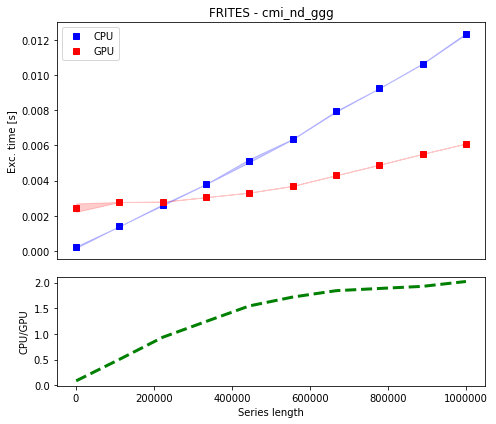

In [11]:
plt.figure(figsize=(7,6))
plt.subplot2grid((3,2), (0,0), rowspan = 2, colspan = 2)
plt.plot(N_arr, exta[0], 'sb', label = 'CPU')
plt.fill_between(N_arr, exta[0]-2*exts[0], exta[0]+2*exts[0], color = 'b', alpha = .2)
plt.plot(N_arr, exta[1], 'sr', label = 'GPU')
plt.fill_between(N_arr, exta[1]-2*exts[1], exta[1]+2*exts[1], color = 'r', alpha = .2)
plt.xticks([])
plt.title('FRITES - cmi_nd_ggg')
plt.ylabel('Exc. time [s]')
plt.legend()
plt.subplot2grid((3,2), (2,0), rowspan = 1, colspan = 2)
plt.plot(N_arr, exta[0]/exta[1], 'g--', lw = 3)
plt.ylabel(r'CPU/GPU')
plt.xlabel('Series length')
plt.tight_layout()
plt.savefig('cmi_nd_ggg.pdf', dpi = 600)